# **Letter classification algorithm**

# Read database

Functions used to read the database (train and test) from MNIST and also from the csv file generated with the images captured from the pico camera

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

import pandas as pd
from sklearn.externals import joblib
import string

# Generate datasets

In [2]:
import dataTools as dt

In [3]:
%%time

X_train, Y_train = dt.create_train_data(0.1)

Generating TRAIN data...
Creating dataset...
Number of the lines in the dataset: 120000
Number of the lines in the dataset: 12000

Finished creating dataset

CPU times: user 2min 19s, sys: 2.83 s, total: 2min 21s
Wall time: 2min 21s


In [4]:
%%time

X_test, Y_test = dt.create_test_data(0.1)

Generating TEST data...
Creating dataset...
Number of the lines in the dataset: 6150
Number of the lines in the dataset: 615

Finished creating dataset

CPU times: user 6.75 s, sys: 24.1 ms, total: 6.77 s
Wall time: 6.77 s


In [5]:
%%time

X_validation, Y_validation = dt.create_validation_data(0.1)

Generating VALIDATION data...
Creating dataset...
Number of the lines in the dataset: 14350
Number of the lines in the dataset: 1435

Finished creating dataset

CPU times: user 15.8 s, sys: 104 ms, total: 15.9 s
Wall time: 15.9 s


# **Decision Tree algorithm**

In [6]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = string.ascii_uppercase
    
    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.figure(figsize=(15,12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [7]:
def train_decisionTreeModel(i):  
    #Train the classifier
    print("Training DecisionTree classifier...")
    clf = DecisionTreeClassifier(random_state = 0, max_depth = i)
    print("Finished trainning DecisionTree classifier with " + str(i) + " depth")
    
    # Training DecisionTree
    return clf.fit(X_train, Y_train)

decisionTree_classificator = train_decisionTreeModel(10)

Training DecisionTree classifier...
Finished trainning DecisionTree classifier with 10 depth


The accuracy for test database is: 47.983%
Using: 12000 images


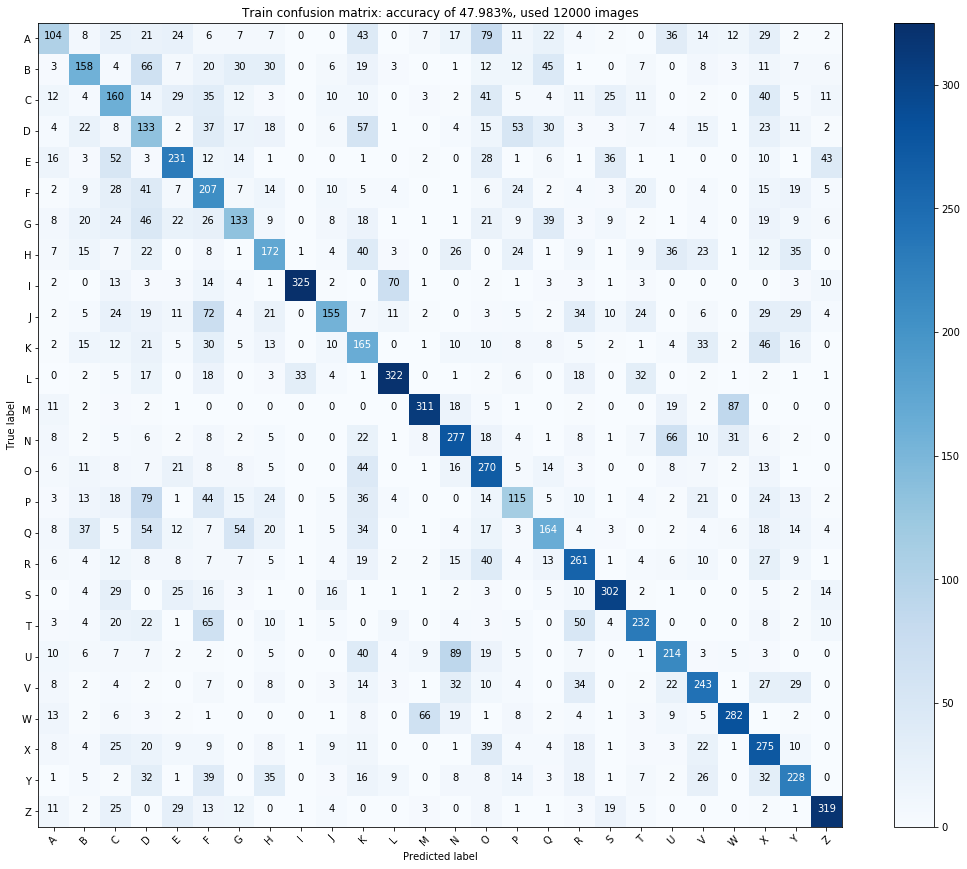

In [8]:
# Compute prediction accuracy on training set
def visualize_decisionTreeModel():
    predicted = decisionTree_classificator.predict(X_train)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_train, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_train)) + " images")
    
    plot_confusion_matrix(decisionTree_classificator, X_train, Y_train)
    plt.title('Train confusion matrix: accuracy of ' + str(round((accuracy_score(Y_train, predicted) * 100), 3)) + "%, used " + str(len(X_train)) + " images")
    plt.savefig('./Results/decisionTree/train')

visualize_decisionTreeModel()

The accuracy for test database is: 34.564%
Using: 1435 images


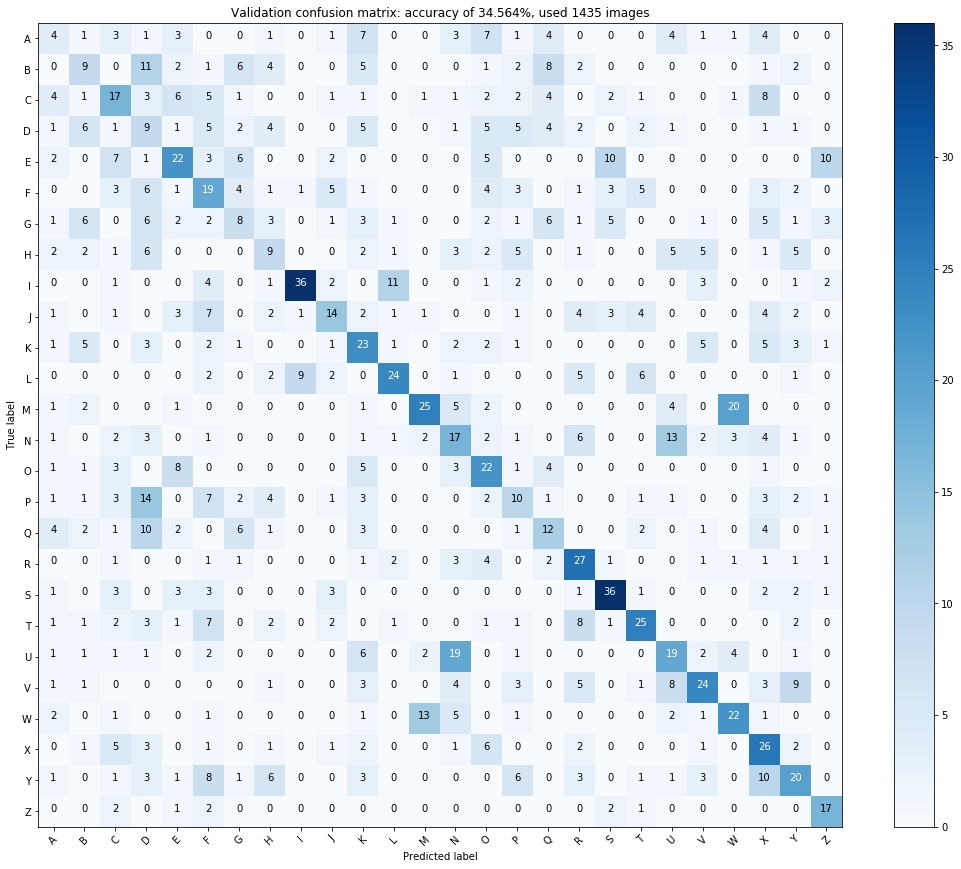

In [9]:
# Compute prediction accuracy on testing set
def validation_decisionTreeModel():
    predicted = decisionTree_classificator.predict(X_validation)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_validation, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_validation)) + " images")
    
    plot_confusion_matrix(decisionTree_classificator, X_validation, Y_validation)
    plt.title('Validation confusion matrix: accuracy of ' + str(round((accuracy_score(Y_validation, predicted) * 100), 3)) + "%, used " + str(len(X_validation)) + " images")
    plt.savefig('./Results/decisionTree/validation')

validation_decisionTreeModel()

# **Evaluation methods**

This part contains the functions used to analyse the accuracy of the classifier

# **Multiple Hyperparameter Study**
This part consist in making a study of the hyperparameter of the classifier, using the gridsearch method from the scikitlearn library.

In [17]:
# Define the parameter values that should be searched
depth_range = list(range(1, 20))

# Another parameter besides max_depth that we might vary is the criteria
criterion_options = ['gini', 'entropy']
#features_options = ['auto', 'sqrt','log2', None]

# Specify "parameter grid"
param_grid = dict(max_depth=depth_range, criterion=criterion_options)

# Specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(max_depth=depth_range, criterion=criterion_options)

# Since both parameters are discrete, so param_dist is the same as param_grid

# Finally define the classifier, in this case the DecisionTree classifier
decisionTree = DecisionTreeClassifier()

In [18]:
%%time

grid_best_scores = []
grid_best_params = []
grid_best_estimator = []

rand_best_scores = []
rand_best_params = []
rand_best_estimator = []

for i in list(range(15)):
    print i
    grid = GridSearchCV(decisionTree, param_grid, cv=10, scoring='accuracy', n_jobs = -1)
    grid.fit(X_train, Y_train)
    grid_best_scores.append(grid.best_score_)
    grid_best_params.append(grid.best_params_)
    grid_best_estimator.append(grid.best_estimator_)

    rand = RandomizedSearchCV(decisionTree, param_dist, cv=10, scoring='accuracy', n_iter=10, n_jobs = -1)
    rand.fit(X_train, Y_train)
    rand_best_scores.append(rand.best_score_)
    rand_best_params.append(rand.best_params_)
    rand_best_estimator.append(rand.best_estimator_)
    
print("Finished searching the hyper parameters!")


Finished searching the hyper parameters!
CPU times: user 9min 20s, sys: 17.9 s, total: 9min 38s
Wall time: 7h 4min 45s


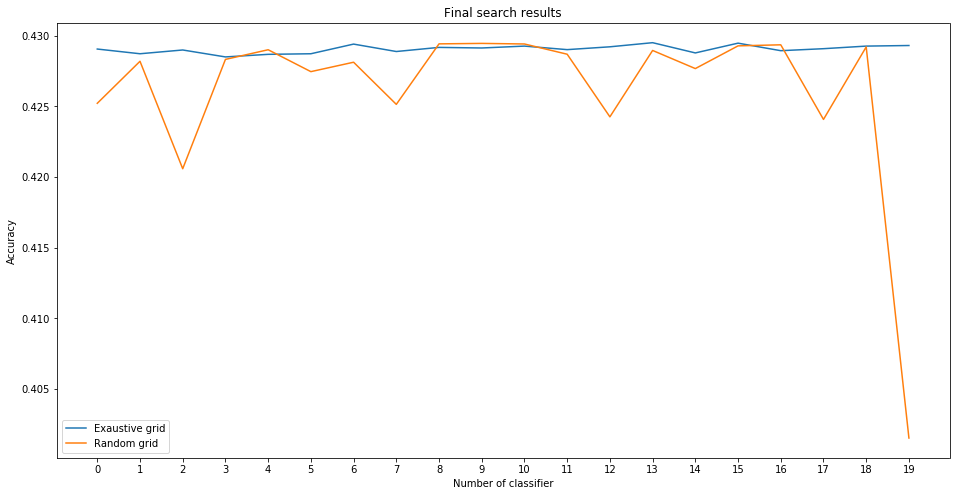

GRID SEARCH RESULTS
The best accuracy is: 42.95166666666667%
The parameters is: {'criterion': 'gini', 'max_depth': 15}


RANDOMGRID SEARCH RESULTS
The best accuracy is: 42.946666666666665%
The parameters is: {'criterion': 'gini', 'max_depth': 15}


In [19]:
# This block draw accuracies of the differents classifiers used in the grid and random search

plt.figure(figsize=(16, 8))
plt.title("Final search results")   
plt.plot(range(len(grid_best_scores)), grid_best_scores, label = 'Exaustive grid')
plt.plot(range(len(rand_best_scores)), rand_best_scores, label = 'Random grid')
plt.xlabel('Number of classifier')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(len(grid_best_scores)))
plt.show()

print("GRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(grid_best_scores) * 100) + "%")
print("The parameters is: " + str(grid_best_params[np.argmax(grid_best_scores)]))
print('\n')
print("RANDOMGRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(rand_best_scores) * 100) + "%")
print("The parameters is: " + str(rand_best_params[np.argmax(rand_best_scores)]))

# Best DecisionTree classificator

In [20]:
#Train the best classificator for a N sample of numbers
def train_best_classifier():   
    classificator = rand_best_estimator[np.argmax(rand_best_scores)]

    return classificator.fit(X_train, Y_train)

In [21]:
best_decisionTree_classificator = train_best_classifier()

The accuracy for test database is: 42.992%
Using: 6150 images


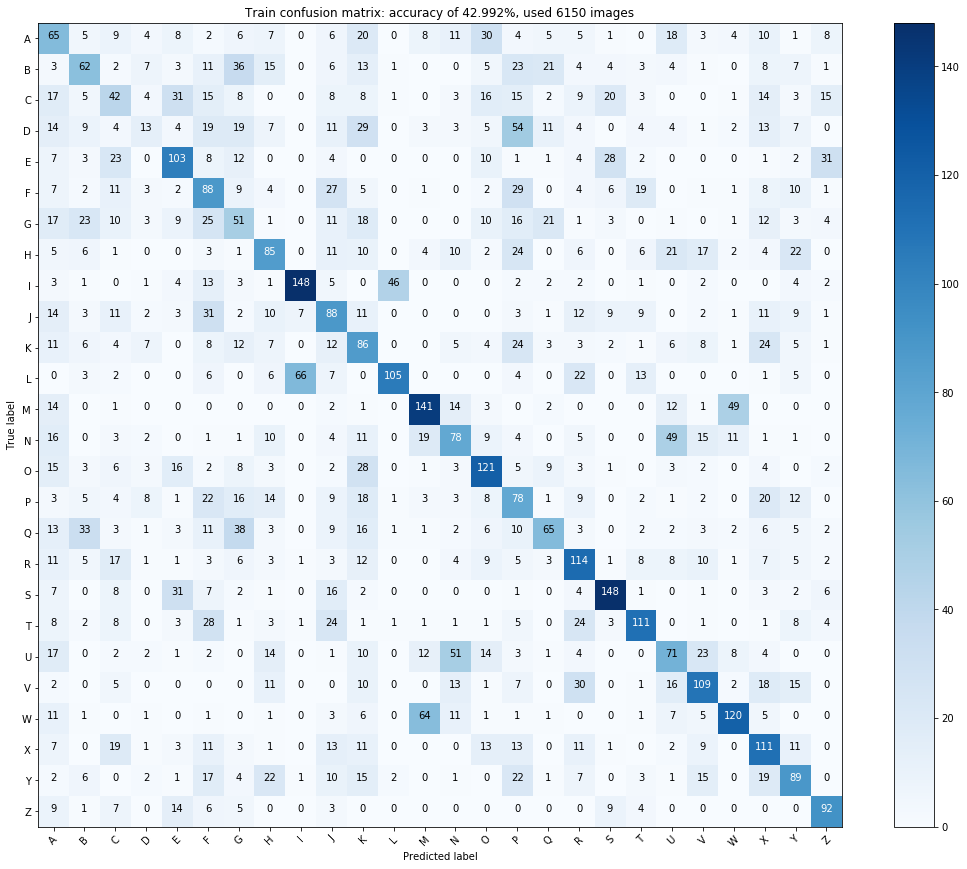

In [22]:
# Compute prediction accuracy on testing set
def test_decisionTreeModel():
    predicted = best_decisionTree_classificator.predict(X_test)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_test, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_test)) + " images")
    
    plot_confusion_matrix(decisionTree_classificator, X_test, Y_test)
    plt.title('Train confusion matrix: accuracy of ' + str(round((accuracy_score(Y_test, predicted) * 100), 3)) + "%, used " + str(len(X_test)) + " images")
    plt.savefig('./Results/decisionTree/test')

test_decisionTreeModel()

# Save model

In [23]:
# save the classifier
filename = './../application/decisionTree/decisionTree_classifier.sav'
joblib.dump(decisionTree_classificator, filename, compress = 3)  

['./../../aplication/decisionTree/decisionTree_classifier.sav']

In [24]:
# save the classifier
filename = './../application/decisionTree/best_decisionTree_classifier.sav'
joblib.dump(best_decisionTree_classificator, filename, compress = 3)  

['./../../aplication/decisionTree/best_decisionTree_classifier.sav']

# Features study for decisionTree classifier

In a decisionTree model the feature used to make the classification is very important, so in this part it is made a study on the best feature

In [25]:
#This part displays the table of importance of each feature

bins = np.arange(len(training_set.digits[0].features))
label_list = []
for feature in training_set.digits[0].features:
    label_list.append(feature)

importance = best_decisionTree_classificator.feature_importances_
df = pd.DataFrame({'feature': label_list, 'Level of importance': importance})
df.sort_values(by = ['Level of importance']).reset_index()

,index,Level of importance,feature
0,6,0.026063,std
1,3,0.026757,var
2,0,0.043175,std_grad_M
3,11,0.044083,mean_PC_X
4,4,0.045200,active_PC_X
5,5,0.051620,active_PC_Y
6,10,0.051647,mean_PC_Y
7,8,0.113202,std_PC_Y
8,7,0.128626,std_PC_X
9,1,0.132656,mean_grad_D


[Text(0,0,'std_grad_M'),
 Text(0,0,'mean_grad_D'),
 Text(0,0,'std_grad_D'),
 Text(0,0,'var'),
 Text(0,0,'active_PC_X'),
 Text(0,0,'active_PC_Y'),
 Text(0,0,'std'),
 Text(0,0,'std_PC_X'),
 Text(0,0,'std_PC_Y'),
 Text(0,0,'mean_grad_M'),
 Text(0,0,'mean_PC_Y'),
 Text(0,0,'mean_PC_X')]

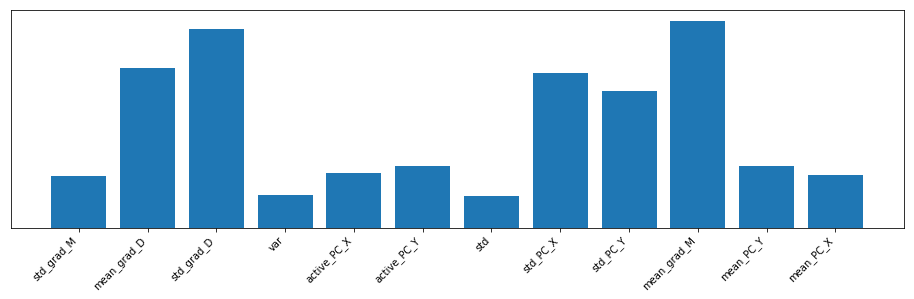

In [26]:
# This part plots a grafic for better visualization

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
ax.bar(bins, importance)
ax.set_xticks(np.arange(len(label_list)))
ax.set_yticks([])
ax.set_xticklabels(label_list, rotation = 45, ha = 'right')
# Display bar graph of feature importances with feature names as labels